**Import necessary packages**

In [1]:
# Importing libraries
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, BatchNormalization, GRU, LayerNormalization, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l1_l2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from itertools import product
from matplotlib.legend_handler import HandlerBase
import matplotlib.cm as cm
import matplotlib.patches as patches
import seaborn as sns
import matplotlib.patches as patches
from sklearn.metrics import roc_auc_score, roc_curve, auc
%cd /ceph/hpc/home/novljanj/data_storage/projects/LIN28A_associated/results/Trying_CNNs


2024-03-22 12:03:24.937988: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 12:03:33.845672: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/ceph/hpc/data/ki-erc/jnovljan/projects/LIN28A_associated/results/Trying_CNNs


**Remove the 5% longest sequences in the dataset - makes machine learning perform better since there is less padding on all sequences.**

In [53]:
#SUBSET 95% of the data

# Import dataset
dataset = pd.read_table(r'analysis13_MachineLearningOnQuantSeqGroups/QuantseqGroups_with_fa.bed', header=None)

# Print the number of reads before subsetting
print("Number of reads before subsetting:", len(dataset))

# Sort the dataset by sequence length
sorted_dataset = dataset.sort_values(by=[7], key=lambda x: x.str.len())

# Calculate the total number of sequences
total_sequences = len(sorted_dataset)

# Calculate the number of sequences that represent 95% of the shortest sequences
cutoff_index = int(0.95 * total_sequences)

# Select the first n sequences from the sorted dataset
dataset_subset = sorted_dataset.iloc[:cutoff_index]

# Export the sequences in the subsetted dataset
print("Number of sequences in the subsetted dataset:", len(dataset_subset))
dataset_subset.to_csv('analysis13_MachineLearningOnQuantSeqGroups/dataset_subset_95.bed', sep="\t", index = False, header=False)

Number of reads before subsetting: 4876
Number of sequences in the subsetted dataset: 4632


In [3]:
dataset_subset

,0,1,2,3,4,5,6,7
2076,chr4,133819715,133819815,CONTROL,-0.141645,+,ENSMUSG00000012123,TGAACCAACCAACGCCATCACCAGTTTCCTTCAGGAGGCTTTTGCT...
604,chr7,19314481,19314581,DOWN,-1.142632,+,ENSMUSG00000011267,TGAGCCATATTCTCTGTACAGGTGTCACTAAAGCAAGTGGAAATGG...
2840,chr11,97921217,97921318,CONTROL,0.110861,+,ENSMUSG00000017404,TAAAGCTTCCCTCGTGTCTGTACATAGCGGCCTGGCTGTGGCCTCA...
1073,chr11,95938155,95938256,DOWN,-0.701914,+,ENSMUSG00000006058,TGACTGAGTGTGGAGGGGTAGACAGCAGCAGGCCAGAAGATGCCCT...
3131,chr16,93702902,93703003,CONTROL,0.194352,+,ENSMUSG00000022945,TGAGCCTGCTATGCACCTGCGTGCAGAGGAGGCAAGGCCAAAGCTC...
...,...,...,...,...,...,...,...,...
49,chr13,51303194,51306582,DOWN,-2.580964,+,ENSMUSG00000021395,TAGATGTCATCACAAACTTTGCCAAATTTGTGGAACTATTAAATGT...
2000,chr12,100172684,100176073,CONTROL,-0.170782,+,ENSMUSG00000001175,TGAAGACCTACTTTCAACTACTTTTCCCCCTCTAGAAGAATCAAAT...
2784,chr8,26254565,26257954,CONTROL,0.095808,-,ENSMUSG00000037316,TGAAATAACTTGGAATGCAGGGGAGCCTGTGACTGATTTGGCCAAA...
2392,chr5,122458934,122462344,CONTROL,-0.037340,+,ENSMUSG00000038582,TGATGGGCCACACTGGTGACTCCTGCCTTTCCCCTGTCTCCCGACT...


**Training a hybrid machine learning network consisting of multiple Convolutional layers and a GRU layer.**

In [33]:
# One-hot encoding
def one_hot_encode(sequence):
    encoding_map = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'N': [0, 0, 0, 0]
    }
    one_hot = [encoding_map[s] for s in sequence]
    return np.array(one_hot)

# Preprocessing of the sequences with padding and one-hot encoding
def preprocess_one_hot_encode_sequence(dataset_subset):

    # Pad sequences to the maximum sequence length with Ns
    max_length = dataset_subset['sequence'].str.len().max()
    dataset_subset['padded_sequence'] = dataset_subset['sequence'].apply(lambda x: x.ljust(max_length, 'N'))

    # One-hot encode the padded DNA sequences
    dataset_subset['encoded_sequence'] = dataset_subset['padded_sequence'].apply(one_hot_encode)

    # Select only UP and DOWN classes
    up_down_subset = dataset_subset[(dataset_subset['classification'] == 'UP') | (dataset_subset['classification'] == 'DOWN')]

    # Convert the classification column to a binary category column
    up_down_subset['category'] = np.where(up_down_subset['classification'] == 'UP', 0, 1)

    # Reset the index of the new subset
    up_down_subset = up_down_subset.reset_index(drop=True)

    return up_down_subset

   
# Convert log2fold change data to categorical labels, subset UP and DOWN categories and split the data into training, validation and testing sets.
def make_train_test_categorical(dataset): 

    # Get the X and y values for machine learning
    X = np.stack(dataset['encoded_sequence'].values)
    y = to_categorical(dataset['category'].values)

    # Split the data into constant training, validation, and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state=11, test_size=0.34, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=11, test_size=0.5, stratify=y_temp)

    return X_train, X_val, X_test, y_train, y_val, y_test

# Build the model based on Seluki paper, the hyperparameters have been optimised with optuna.
def build_conv1d_model1(input_shape, num_classes):
    l2_coeff = 0.9
    l1_coeff = 0.0008
    dropout_prob = 0.34
    neurons = 64
    layers = 3

    model = tf.keras.Sequential()
    # Tower of convolution blocks
    model.add(Conv1D(filters=neurons, kernel_size=5, kernel_regularizer=l1_l2(l1=l1_coeff, l2=l2_coeff), input_shape=input_shape))
    model.add(LayerNormalization())
    model.add(ReLU())

    for _ in range(layers):
        model.add(Conv1D(filters=neurons, kernel_size=5, kernel_regularizer=l1(l1_coeff)))
        model.add(Dropout(rate=dropout_prob))
        model.add(MaxPooling1D(pool_size=2))
        model.add(LayerNormalization())
        model.add(ReLU())

    # Gated Recurrent Unit (GRU)
    model.add(GRU(units=neurons, go_backwards=True, kernel_regularizer=l1(l1_coeff)))
    model.add(BatchNormalization())
    model.add(ReLU())

    # Dense block
    model.add(Dense(units=neurons, kernel_regularizer=l1(l1_coeff)))
    model.add(BatchNormalization())
    model.add(ReLU())

    # Final layer applies softmax function to output for each class
    model.add(Dense(units=num_classes, activation='softmax')) 

    return model

# Train the model 
def train_model(input_shape, num_classes):
    model = build_conv1d_model1(input_shape, num_classes)

    # Define Adam optimiser with learning rate, beta_1, beta_2 and clipnorm defined
    optimizer = Adam(learning_rate=5e-05, beta_1=0.9, beta_2=0.98, clipnorm=0.5)

    # Compile the model with loss and metrics specific for a categorical problem
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Print the model summary
    model.summary()

    # Define early stopping callback so the model doesn't overfit in later stages of training
    early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

    # Train the model for ~infinite number of epochs with early stopping callback
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10000, batch_size=64, callbacks=[early_stopping], verbose=1)

    return model, history

#MAIN
# Import the subsetted dataset
dataset_subset = pd.read_table(r'analysis13_MachineLearningOnQuantSeqGroups/dataset_subset_95.bed', header=None, names= ['chromosome', 'start', 'end', 'classification', 'log2fold', 'strand', 'gene_name', 'sequence'])
# Preprocess the dataset
preprocessed_dataset_subset = preprocess_one_hot_encode_sequence(dataset_subset)
# Split the data into training, validation, and testing sets
X_train, X_val, X_test, y_train, y_val, y_test = make_train_test_categorical(preprocessed_dataset_subset)
# Get the input shape and number of classes
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]
# Train the model
#model, history = train_model(input_shape, num_classes) 
# Save the model
#model.save('analysis13_MachineLearningOnQuantSeqGroups/trained_model.h5')

/tmp/ipykernel_497033/1586761768.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_down_subset['category'] = np.where(up_down_subset['classification'] == 'UP', 0, 1)


In [ ]:
# Load the any model - my_model_for_deeplift.h5 is the best performing one
model = load_model('analysis13_MachineLearningOnQuantSeqGroups/trained_model.h5')

# Predict y_pred from X_test
y_pred = model.predict(X_test)

# Calculate the AUROC score
# Take the probabilities for the positive class only
y_pred_prob = y_pred[:, 1]

# Ensure y_test is not one-hot encoded
y_test_classes = np.argmax(y_test, axis=1)

y_df = pd.DataFrame({'Predicted': y_pred_prob, 'True': y_test_classes})
y_df.to_csv('analysis13_MachineLearningOnQuantSeqGroups/predicted_and_true_values.csv', index=False)

In [41]:
y_df

,Predicted,True
0,0.931746,1
1,0.880881,1
2,0.837850,0
3,0.959728,1
4,0.356756,1
...,...,...
346,0.900726,1
347,0.008825,0
348,0.865139,1
349,0.862795,1


AUROC: 0.888252617801047


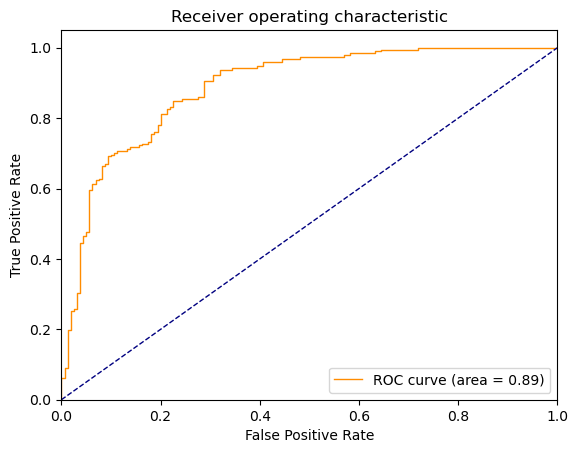

Accuracy: 0.811965811965812
Precision: 0.827529114355331
Recall: 0.811965811965812
F1-score: 0.8070748045975411


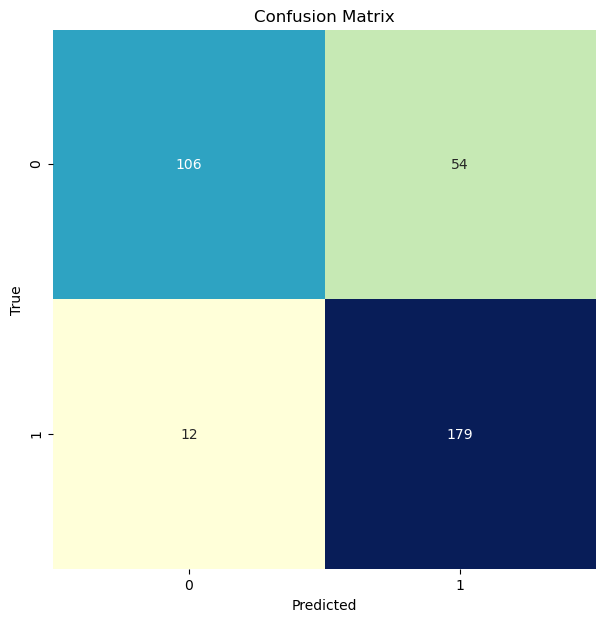

In [49]:
y_df = pd.read_csv('analysis13_MachineLearningOnQuantSeqGroups/predicted_and_true_values.csv')

# Convert DataFrame columns back to numpy arrays
y_pred_prob = y_df['Predicted'].to_numpy()
y_test_classes = y_df['True'].to_numpy()

auroc = roc_auc_score(y_test_classes, y_pred_prob)
print("AUROC:", auroc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_classes, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# Export the ROC curve as svg
plt.savefig('ROC_curve.svg', format='svg', dpi=600)
plt.show()

# Get the predicted classes if 0.5 is the threshold
y_pred_classes = np.where(y_pred_prob > 0.5, 1, 0)

# Get the accuracy score
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy:", accuracy)
# Get the precision score
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
print("Precision:", precision)
# Get the recall score
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
print("Recall:", recall)
# Get the F1-score
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print("F1-score:", f1)

# Plot the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**Load the trained model**

In [ ]:
model = load_model('analysis13_MachineLearningOnQuantSeqGroups/trained_model.h5')

**Calculate contribution scores using SHAP (SHapley Additive exPlanations) for each nucleotide in sequences.**

In [ ]:
# Use SHAP (SHapley Additive exPlanations) to explain the model's predictions for all sequences in dataset (training, testing and validation set)
    # Heads-up: runs for a long time - ~15min
explainer = shap.GradientExplainer(Model(inputs=model.inputs, outputs=model.output), np.stack(dataset_subset['encoded_sequence'].values))
shap_values = explainer.shap_values(np.stack(preprocessed_dataset_subset['encoded_sequence'].values))

# Export all down class prediction scores as numpy files
np.save('analysis13_MachineLearningOnQuantSeqGroups/hot-endcoded-seqs_down_all.npy', preprocessed_dataset_subset['encoded_sequence'])
np.save('analysis13_MachineLearningOnQuantSeqGroups/contribution-scores_down_all.npy', shap_values[1])

# Export all up class prediction scores as numpy files
np.save('analysis13_MachineLearningOnQuantSeqGroups/hot-endcoded-seqs_up_all.npy', preprocessed_dataset_subset['encoded_sequence'])
np.save('analysis13_MachineLearningOnQuantSeqGroups/contribution-scores_up_all.npy', shap_values[0])

**Load a numpy array from files.**

In [6]:
# Load a numpy array from files
hot_endcoded_seqs_down_all = np.load('hot-endcoded-seqs_down_all.npy', allow_pickle=True)
contribution_scores_down_all = np.load('contribution-scores_down_all.npy', allow_pickle=True)

hot_endcoded_seqs_up_all = np.load('hot-endcoded-seqs_up_all.npy', allow_pickle=True)
contribution_scores_up_all = np.load('contribution-scores_up_all.npy', allow_pickle=True)

**Remove padding from the sequences**

In [7]:
# Remove padding from the sequences
def remove_padding(hot_encoded_seqs, contribution_scores):
    # Create empty lists
    non_padded_seqs = []
    non_padded_scores = []
    # Loop through the sequences and scores and remove the [0,0,0,0] padding
    for seq, score in zip(hot_encoded_seqs, contribution_scores):
        # Create a mask where non-padding positions are True
        mask = np.any(seq != [0,0,0,0], axis=-1)  
        # Apply the mask
        non_padded_seqs.append(seq[mask])
        non_padded_scores.append(score[mask])
    
    return non_padded_seqs, non_padded_scores

# Remove padding from all arrays
non_padded_seqs_down_all, non_padded_scores_down_all = remove_padding(hot_endcoded_seqs_down_all, contribution_scores_down_all)
non_padded_seqs_up_all, non_padded_scores_up_all = remove_padding(hot_endcoded_seqs_up_all, contribution_scores_up_all)


**Decode the one-hot encoding of the sequences**

In [9]:
encoding_map = {
    'A': [1, 0, 0, 0],
    'C': [0, 1, 0, 0],
    'G': [0, 0, 1, 0],
    'T': [0, 0, 0, 1],
    'N': [0, 0, 0, 0]
}

inverse_encoding_map = {tuple(value): key for key, value in encoding_map.items()}

def decode_sequence(input_sequence):
    decoded_sequence = ''
    for encoded_nucleotide in input_sequence:
        nucleotide = inverse_encoding_map.get(tuple(encoded_nucleotide), 'N')
        if nucleotide != 'N':
            decoded_sequence += nucleotide
        else:
            break
    return decoded_sequence

# Decode the sequences
decoded_sequences_down_all = [decode_sequence(seq) for seq in non_padded_seqs_down_all]
decoded_sequences_up_all = [decode_sequence(seq) for seq in non_padded_seqs_up_all]

**Draw a metaplot linegraph of the contribution scores for each nucleotide at every position in binned sequences**

In [ ]:
def find_maximum_value(list_of_lists):
    # Initialize max_value with negative infinity
    max_value = float('-inf')

    # Loop through the list of lists and find the maximum value
    for inner_list in list_of_lists:
        for element in inner_list:
            if element > max_value:
                max_value = element
    return max_value

# Create a function that scores for kmer at each position in the sequence and then bins the sequences, sums the socres for each bin and plots them.
def create_aggregate_heatmap_per_kmers(seqs, scores, k_mer, num_bins, group, kmer_name):
    # Generate all possible kmers
    nucleotides = ['A','T', 'C', 'G'] # Can be changed if you want to see only kmer from ceirtain nucleotides
    # Create a list of all possible kmers
    kmers = [''.join(kmer) for kmer in product(nucleotides, repeat=k_mer)]
    
    # Create an empty array for the heatmap data
    heatmap_data = np.zeros((len(kmers), num_bins))

    # Create a dictionary to map nucleotides to indices
    nucleotide_to_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    
    # For each kmer
    for n, kmer in enumerate(kmers):
        # Create empty lists for relative positions and scores
        relative_positions_all = []
        scores_all = []

        # For each sequence and score
        for seq, score in zip(seqs, scores):

            # For each possible position of the kmer in the sequence
            for j in range(len(seq) - len(kmer)+1):

                # Calculate the mean score for this position
                mean_score = np.mean([score[j+i][nucleotide_to_index[kmer[i]]] for i in range(len(kmer))])

                # Append the mean score and relative position to the lists
                scores_all.append(mean_score)
                relative_positions_all.append((j/len(seq)))

        # Skip if no scores for this kmer
        if not scores_all:
            continue

        # Create a DataFrame for easy binning
        df = pd.DataFrame({
            'RelativePosition': relative_positions_all,
            'Score': scores_all
        })

        # Bin the data according to relative position
        df['Bin'] = pd.cut(df['RelativePosition'], bins=num_bins, labels=False)

        # Group by bin and calculate mean of scores
        df_mean_scores = df.groupby('Bin')['Score'].mean().reset_index()

        # Add the scores for this kmer to the heatmap data
        heatmap_data[n] = df_mean_scores['Score'].values

    # Find the maximum value in the heatmap data
    vmax = find_maximum_value(heatmap_data)
    max_score.append(vmax)
    vmax = max(max_score)

    return heatmap_data, kmer_name, group, num_bins, kmers, vmax

# If you are drawing multiple plots at the same time, run the code to find max score and then add it to this list so it will later be the same for all plots
max_score=[]    

# Calculate the heatmap for 3-mers
    # Use: create_aggregate_heatmap_per_kmers(decoded_sequences, non_padded_scores, k-mer of interest, number of bins, subset name, k-mer name)
    # Heads-up: this code is inefficient for higher k-mers ~ 20min for 3-mers
heatmap_data, kmer_name, group, num_bins, kmers, vmax = create_aggregate_heatmap_per_kmers(decoded_sequences_down_all, non_padded_scores_down_all, 1, 100, 'DOWN', 'Nucleotides')

# Transpose the array to make it (100, 4) and then convert to DataFrame
heatmap_df = pd.DataFrame(heatmap_data.T)

heatmap_df['kmer_name'] = kmer_name  # Add as a new column
heatmap_df['group'] = group  # Add as a new column
heatmap_df['num_bins'] = num_bins  # Add as a new column
heatmap_df['kmers'] = str(kmers) # Add as a new column
heatmap_df['vmax'] = vmax  # Add as a new column

# save the heatmap data as csv
heatmap_df.to_csv('analysis13_MachineLearningOnQuantSeqGroups/importance_of_each_nucleotide_binned.csv', index=False)

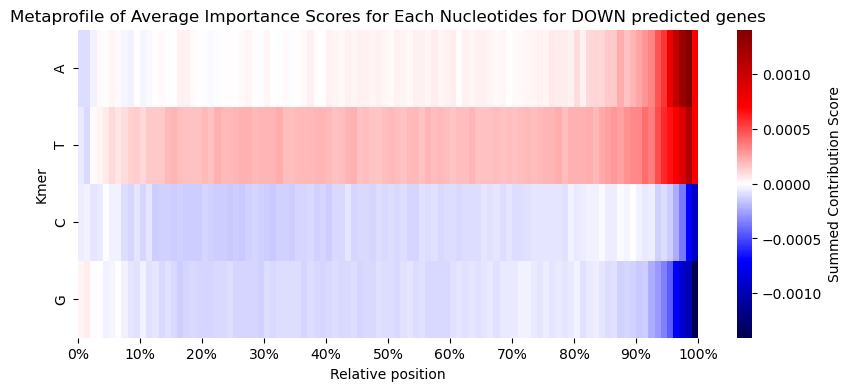

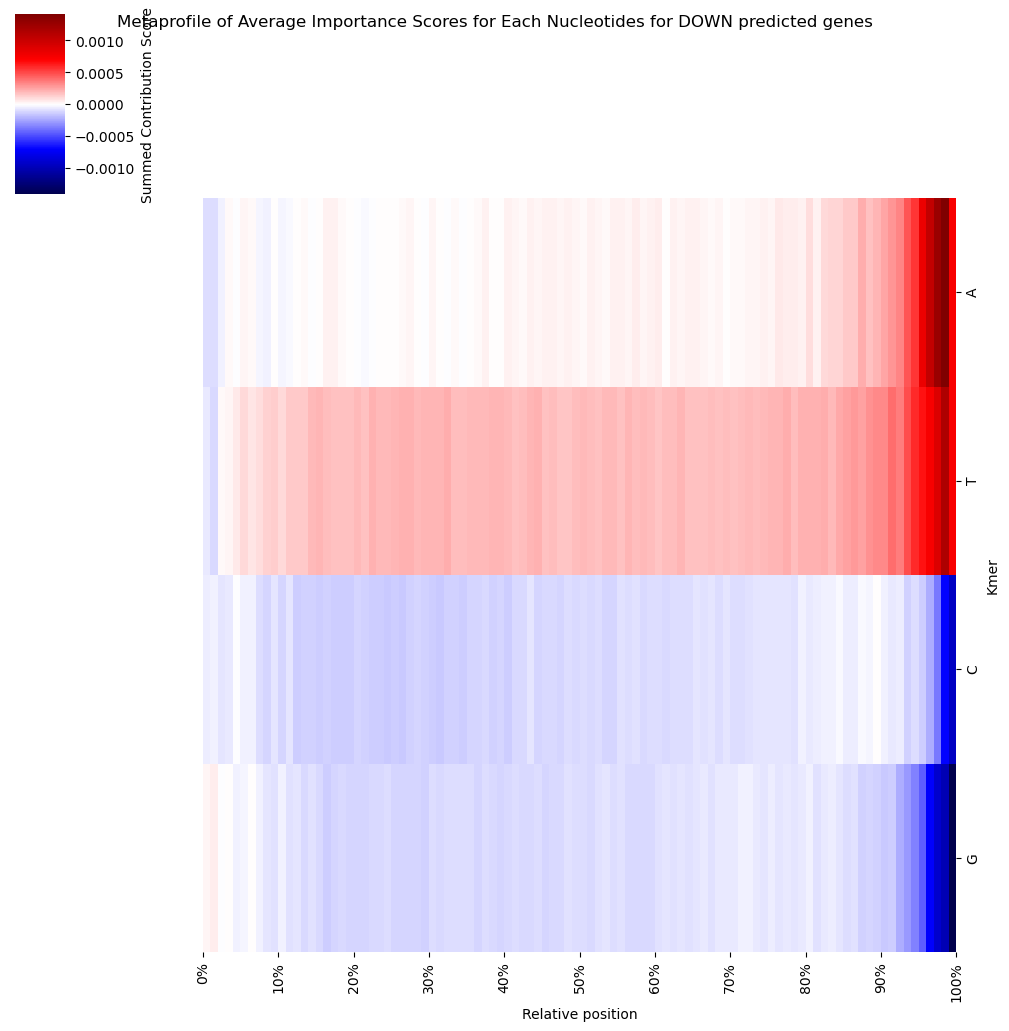

In [17]:
def plot_heatmap(heatmap_data, kmer_name, group, num_bins, kmers, vmax):
    # Plot
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.heatmap(heatmap_data, cmap='seismic', cbar_kws={'label': 'Summed Contribution Score'}, yticklabels=kmers, vmin=-vmax, vmax=vmax, ax=ax)
    ax.set_xlabel('Relative position')
    ax.set_ylabel('Kmer')

    # Set x-ticks
    x_ticks = np.linspace(0, num_bins, 11)  # 11 points for 0%, 10%, ..., 100%
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f'{i*10}%' for i in range(11)])  # labels are 0%, 10%, ..., 100%

    # Set plot name and show the plot
    plt.title(f'Metaprofile of Average Importance Scores for Each {kmer_name} for {group} predicted genes')

    plt.show()
    
    # Plot with clustermap
    clustermap = sns.clustermap(heatmap_data, row_cluster=False, col_cluster=False, cmap='seismic', cbar_kws={'label': 'Summed Contribution Score'}, yticklabels=kmers, vmin=-vmax, vmax=vmax)

    # Relabel the axes
    clustermap.ax_heatmap.set_xlabel('Relative position')
    clustermap.ax_heatmap.set_ylabel('Kmer')

    # Set x-ticks
    x_ticks = np.linspace(0, num_bins, 11)  # 11 points for 0%, 10%, ..., 100%
    clustermap.ax_heatmap.set_xticks(x_ticks)
    clustermap.ax_heatmap.set_xticklabels([f'{i*10}%' for i in range(11)])  # labels are 0%, 10%, ..., 100%

    # Set plot name
    clustermap.fig.suptitle(f'Metaprofile of Average Importance Scores for Each {kmer_name} for {group} predicted genes')

    # Show the plot
    plt.show()
    
# load the heatmap data from csv
heatmap_df = pd.read_csv('analysis13_MachineLearningOnQuantSeqGroups/importance_of_each_nucleotide_binned.csv')
heatmap_data, kmer_name, group, num_bins, kmers, vmax = heatmap_df.iloc[:, :4].to_numpy().T, heatmap_df['kmer_name'].iloc[0], heatmap_df['group'].iloc[0], heatmap_df['num_bins'].iloc[0], ast.literal_eval(heatmap_df['kmers'].iloc[0]), heatmap_df['vmax'].iloc[0]
    
plot_heatmap(heatmap_data, kmer_name, group, num_bins, kmers, vmax)

**Draw a metaplot linegraph of the contribution scores for trimer at every position in binned sequences**

In [10]:
def find_maximum_value(list_of_lists):
    # Initialize max_value with negative infinity
    max_value = float('-inf')

    # Loop through the list of lists and find the maximum value
    for inner_list in list_of_lists:
        for element in inner_list:
            if element > max_value:
                max_value = element
    return max_value

# Create a function that scores for kmer at each position in the sequence and then bins the sequences, sums the socres for each bin and plots them.
def create_aggregate_heatmap_per_kmers(seqs, scores, k_mer, num_bins, group, kmer_name):
    # Generate all possible kmers
    nucleotides = ['A','T', 'C', 'G'] # Can be changed if you want to see only kmer from ceirtain nucleotides
    # Create a list of all possible kmers
    kmers = [''.join(kmer) for kmer in product(nucleotides, repeat=k_mer)]
    
    # Create an empty array for the heatmap data
    heatmap_data = np.zeros((len(kmers), num_bins))

    # Create a dictionary to map nucleotides to indices
    nucleotide_to_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    
    # For each kmer
    for n, kmer in enumerate(kmers):
        # Create empty lists for relative positions and scores
        relative_positions_all = []
        scores_all = []

        # For each sequence and score
        for seq, score in zip(seqs, scores):

            # For each possible position of the kmer in the sequence
            for j in range(len(seq) - len(kmer)+1):

                # Calculate the mean score for this position
                mean_score = np.mean([score[j+i][nucleotide_to_index[kmer[i]]] for i in range(len(kmer))])
                
                # Append the mean score and relative position to the lists
                scores_all.append(mean_score)
                relative_positions_all.append((j/len(seq)))

        # Skip if no scores for this kmer
        if not scores_all:
            continue

        # Create a DataFrame for easy binning
        df = pd.DataFrame({
            'RelativePosition': relative_positions_all,
            'Score': scores_all
        })

        # Bin the data according to relative position
        df['Bin'] = pd.cut(df['RelativePosition'], bins=num_bins, labels=False)

        # Group by bin and calculate sum of scores
        df_mean_scores = df.groupby('Bin')['Score'].mean().reset_index()

        # Add the scores for this kmer to the heatmap data
        heatmap_data[n] = df_mean_scores['Score'].values

    # Find the maximum value in the heatmap data
    vmax = find_maximum_value(heatmap_data)
    max_score.append(vmax)
    vmax = max(max_score)

    return heatmap_data, kmer_name, group, num_bins, kmers, vmax

# If you are drawing multiple plots at the same time, run the code to find max score and then add it to this list so it will later be the same for all plots
max_score=[]    

# Calculate the heatmap for 3-mers
    # Use: create_aggregate_heatmap_per_kmers(decoded_sequences, non_padded_scores, k-mer of interest, number of bins, subset name, k-mer name)
    # Heads-up: this code is slow for higher k-mers ~ 20min for 3-mers
heatmap_data, kmer_name, group, num_bins, kmers, vmax = create_aggregate_heatmap_per_kmers(decoded_sequences_down_all, non_padded_scores_down_all, 3, 100, 'DOWN', '3-mers')

# Transpose the array to make it (100, 4) and then convert to DataFrame
heatmap_df = pd.DataFrame(heatmap_data.T)

heatmap_df['kmer_name'] = kmer_name  # Add as a new column
heatmap_df['group'] = group  # Add as a new column
heatmap_df['num_bins'] = num_bins  # Add as a new column
heatmap_df['kmers'] = str(kmers) # Add as a new column
heatmap_df['vmax'] = vmax  # Add as a new column

# save the heatmap data as csv
#heatmap_df.to_csv('analysis13_MachineLearningOnQuantSeqGroups/importance_of_each_3mer_binned.csv', index=False)

heatmap_df

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,kmer_name,group,num_bins,kmers,vmax
0,-0.000103,-0.000087,-8.083781e-05,-0.000048,-0.000088,-0.000072,-0.000066,-0.000033,-0.000084,-0.000068,...,0.000011,-1.523975e-05,0.000001,0.000007,0.000040,3-mers,DOWN,100,"['AAA', 'AAT', 'AAC', 'AAG', 'ATA', 'ATT', 'AT...",0.001379
1,-0.000082,-0.000094,-7.362288e-05,-0.000061,-0.000093,-0.000106,-0.000085,-0.000072,-0.000071,-0.000084,...,-0.000002,3.051135e-07,-0.000012,0.000009,0.000021,3-mers,DOWN,100,"['AAA', 'AAT', 'AAC', 'AAG', 'ATA', 'ATT', 'AT...",0.001379
2,-0.000038,-0.000016,-5.691874e-05,-0.000023,-0.000016,0.000006,-0.000035,-0.000002,-0.000042,-0.000020,...,-0.000015,-9.860469e-06,0.000012,-0.000029,0.000005,3-mers,DOWN,100,"['AAA', 'AAT', 'AAC', 'AAG', 'ATA', 'ATT', 'AT...",0.001379
3,0.000007,0.000021,-2.169898e-07,0.000011,0.000021,0.000034,0.000013,0.000025,-0.000016,-0.000002,...,-0.000016,3.575427e-06,0.000017,-0.000004,0.000007,3-mers,DOWN,100,"['AAA', 'AAT', 'AAC', 'AAG', 'ATA', 'ATT', 'AT...",0.001379
4,0.000025,0.000034,2.335822e-06,0.000003,0.000035,0.000044,0.000012,0.000013,0.000007,0.000016,...,-0.000027,-4.701674e-06,0.000004,-0.000028,-0.000027,3-mers,DOWN,100,"['AAA', 'AAT', 'AAC', 'AAG', 'ATA', 'ATT', 'AT...",0.001379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000810,0.000760,4.612739e-04,0.000368,0.000756,0.000706,0.000407,0.000313,0.000481,0.000431,...,-0.000378,-3.800164e-05,-0.000088,-0.000387,-0.000480,3-mers,DOWN,100,"['AAA', 'AAT', 'AAC', 'AAG', 'ATA', 'ATT', 'AT...",0.001379
96,0.001011,0.000932,6.236567e-04,0.000431,0.000931,0.000853,0.000544,0.000351,0.000612,0.000534,...,-0.000531,-1.185343e-04,-0.000197,-0.000506,-0.000699,3-mers,DOWN,100,"['AAA', 'AAT', 'AAC', 'AAG', 'ATA', 'ATT', 'AT...",0.001379
97,0.001232,0.001130,6.655416e-04,0.000531,0.001123,0.001021,0.000556,0.000422,0.000676,0.000574,...,-0.000734,-1.928166e-04,-0.000295,-0.000759,-0.000894,3-mers,DOWN,100,"['AAA', 'AAT', 'AAC', 'AAG', 'ATA', 'ATT', 'AT...",0.001379
98,0.001379,0.001285,6.812943e-04,0.000570,0.001298,0.001204,0.000600,0.000489,0.000680,0.000586,...,-0.000921,-2.248541e-04,-0.000318,-0.000922,-0.001033,3-mers,DOWN,100,"['AAA', 'AAT', 'AAC', 'AAG', 'ATA', 'ATT', 'AT...",0.001379


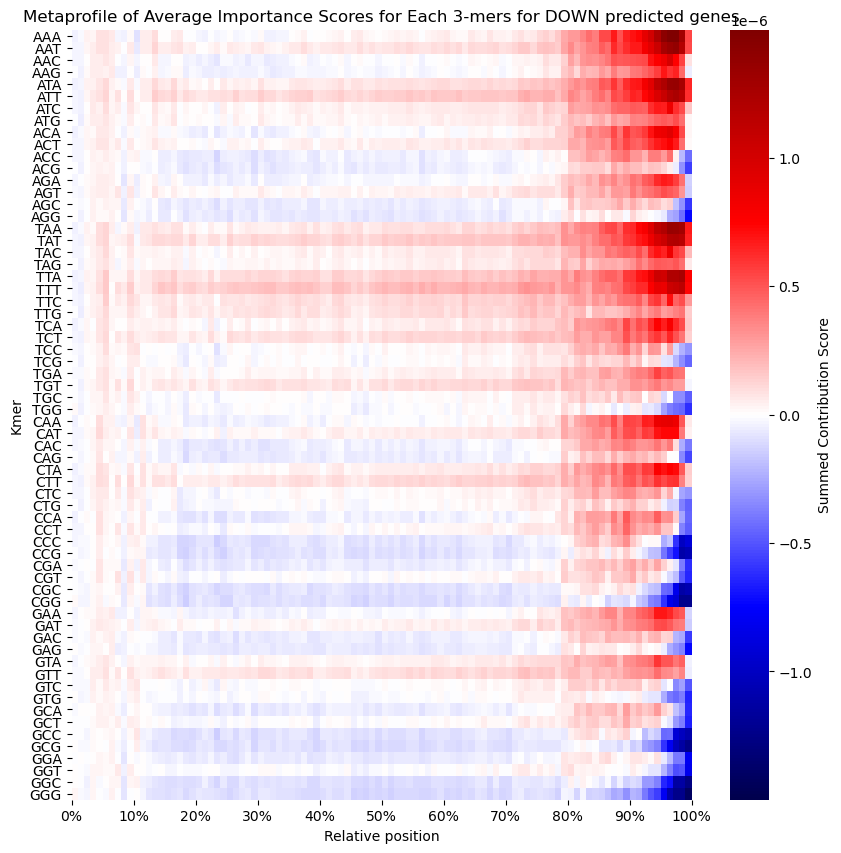

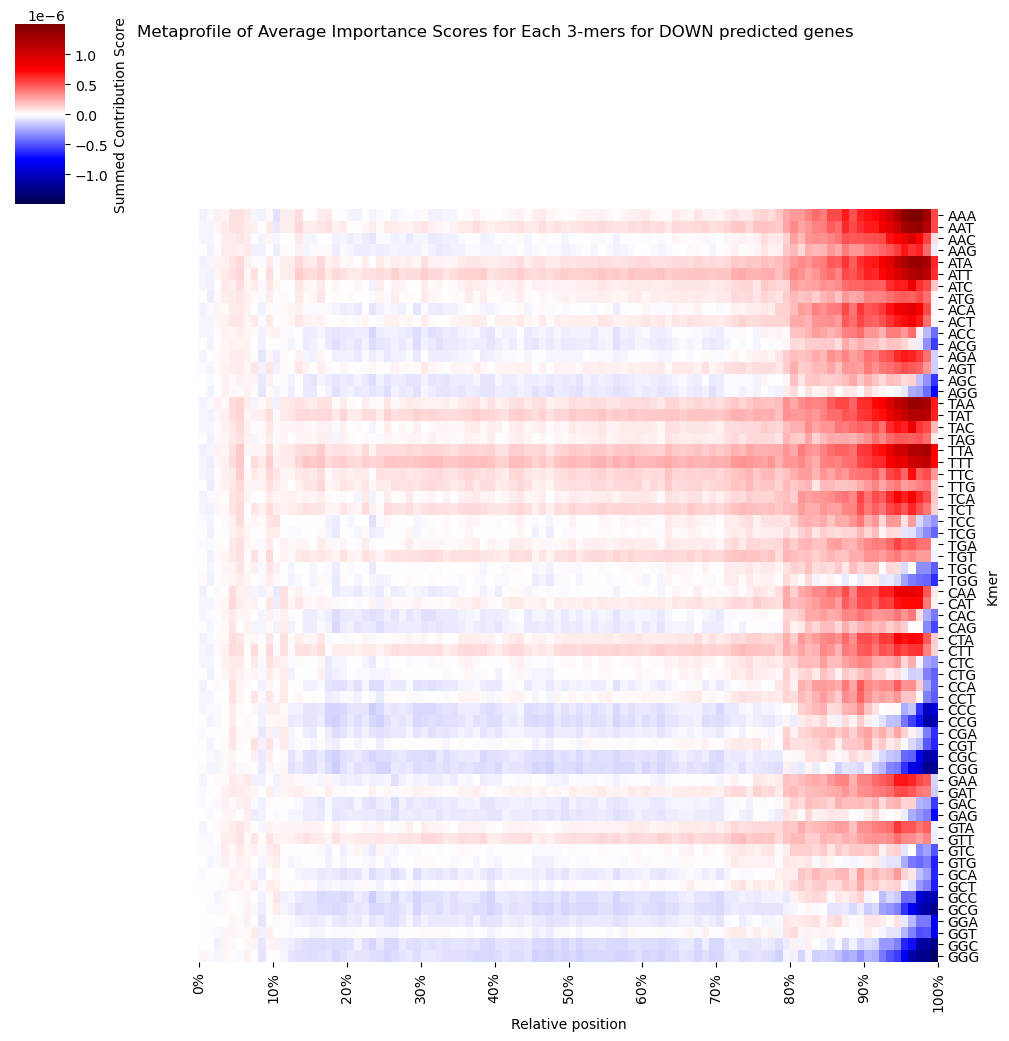

In [23]:
def plot_heatmap(heatmap_data, kmer_name, group, num_bins, kmers, vmax):
    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(heatmap_data, cmap='seismic', cbar_kws={'label': 'Summed Contribution Score'}, yticklabels=kmers, vmin=-vmax, vmax=vmax, ax=ax)
    ax.set_xlabel('Relative position')
    ax.set_ylabel('Kmer')

    # Set x-ticks
    x_ticks = np.linspace(0, num_bins, 11)  # 11 points for 0%, 10%, ..., 100%
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f'{i*10}%' for i in range(11)])  # labels are 0%, 10%, ..., 100%

    # Set plot name and show the plot
    plt.title(f'Metaprofile of Average Importance Scores for Each {kmer_name} for {group} predicted genes')

    plt.show()
    
    # Plot with clustermap
    clustermap = sns.clustermap(heatmap_data, row_cluster=False, col_cluster=False, cmap='seismic', cbar_kws={'label': 'Summed Contribution Score'}, yticklabels=kmers, vmin=-vmax, vmax=vmax)

    # Relabel the axes
    clustermap.ax_heatmap.set_xlabel('Relative position')
    clustermap.ax_heatmap.set_ylabel('Kmer')

    # Set x-ticks
    x_ticks = np.linspace(0, num_bins, 11)  # 11 points for 0%, 10%, ..., 100%
    clustermap.ax_heatmap.set_xticks(x_ticks)
    clustermap.ax_heatmap.set_xticklabels([f'{i*10}%' for i in range(11)])  # labels are 0%, 10%, ..., 100%

    # Set plot name
    clustermap.fig.suptitle(f'Metaprofile of Average Importance Scores for Each {kmer_name} for {group} predicted genes')

    # Show the plot
    plt.show()
    
# load the heatmap data from csv
heatmap_df = pd.read_csv('analysis13_MachineLearningOnQuantSeqGroups/importance_of_each_3mer_binned.csv')
heatmap_data, kmer_name, group, num_bins, kmers, vmax = heatmap_df.iloc[:, :64].to_numpy().T, heatmap_df['kmer_name'].iloc[0], heatmap_df['group'].iloc[0], heatmap_df['num_bins'].iloc[0], ast.literal_eval(heatmap_df['kmers'].iloc[0]), heatmap_df['vmax'].iloc[0]
    
plot_heatmap(heatmap_data, kmer_name, group, num_bins, kmers, vmax)

/tmp/ipykernel_497033/3279368773.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('rainbow_r', len(specified_kmers))


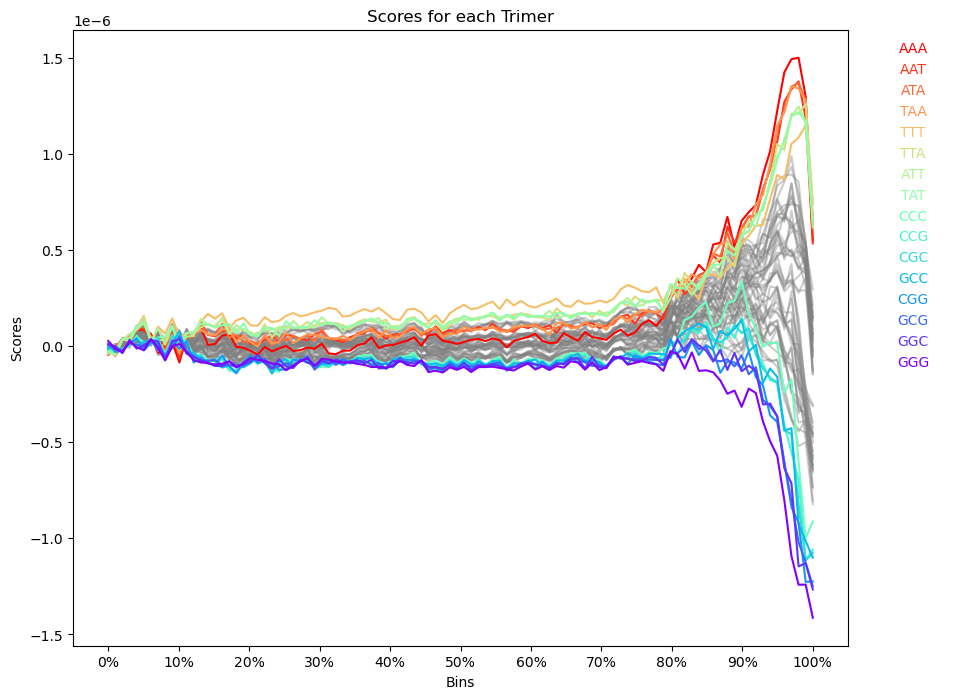

In [24]:
# Creating a custom legend handler
class TextHandler(HandlerBase):
    def create_artists(self, legend, text ,xdescent, ydescent,
                        width, height, fontsize, trans):
        tx = plt.Text(width/2.,height/2, text.get_text(), fontsize=fontsize,
                      ha="center", va="center", color=text.get_color())
        return [tx]

def plot_heatmap_data(heatmap_data, specified_kmers):
    # Generate all possible kmers
    nucleotides = ['A','T', 'C', 'G'] # Can be changed if you want to see only kmer from ceirtain nucleotides
    # Create a list of all possible kmers
    kmers = [''.join(kmer) for kmer in product(nucleotides, repeat=3)]

    # Creating a color map 
    color_map = cm.get_cmap('rainbow_r', len(specified_kmers))

    # Create a new figure with a specified size (width=15, height=10)
    plt.figure(figsize=(10, 8))

    # Plotting gray lines first
    for i, kmer in enumerate(kmers):
        if kmer not in specified_kmers:  # plot gray lines for kmers not in specified_kmers
            plt.plot(heatmap_data[i], color='gray', alpha=0.4)

    # Then plot the lines for specified_kmers in different colors
    legend_texts = []
    for i, kmer in enumerate(specified_kmers):
        if kmer in kmers:
            index = kmers.index(kmer)
            color = color_map(i)
            plt.plot(heatmap_data[index], color=color)
            legend_texts.append(plt.Text(0, 0, kmer, color=color))
            
    # Adding labels and title
    plt.xlabel('Bins')
    plt.ylabel('Scores')

    # Set x-ticks
    x_ticks = np.linspace(0, heatmap_data.shape[1]-1, 11)  # 11 points for 0%, 10%, ..., 100%
    plt.xticks(x_ticks, [f'{int(i*100/(heatmap_data.shape[1]-1))}%' for i in x_ticks])

    plt.title('Scores for each Trimer')

    # Display a legend outside the plot
    plt.legend(handles=legend_texts, frameon=False, handler_map={plt.Text: TextHandler()}, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig('heatmap_data_3mers_down_all_100bins_r_colours.svg', bbox_inches='tight')
    # Displaying the plot
    plt.show()

# load the heatmap data from csv
heatmap_df = pd.read_csv('analysis13_MachineLearningOnQuantSeqGroups/importance_of_each_3mer_binned.csv')
heatmap_data, kmer_name, group, num_bins, kmers, vmax = heatmap_df.iloc[:, :64].to_numpy().T, heatmap_df['kmer_name'].iloc[0], heatmap_df['group'].iloc[0], heatmap_df['num_bins'].iloc[0], ast.literal_eval(heatmap_df['kmers'].iloc[0]), heatmap_df['vmax'].iloc[0]

# Draw the heatmap_data as linegraph
# Specify the kmers you want to highlight
specified_kmers = ['AAA', 'AAT', 'ATA', 'TAA', 'TTT', 'TTA', 'ATT', 'TAT', 'CCC', 'CCG', 'CGC', 'GCC', 'CGG', 'GCG', 'GGC', 'GGG'] # example kmers, replace with your kmers
plot_heatmap_data(heatmap_data, specified_kmers)

**Draw a graph showing the averaged contribution scores for all nucleotides at every position 200bp upstream and 20bp downstream of the PolyA signal**

In [76]:
# Define the range for importance scores calculation
upstream = 100
downstream = 20

# Define the list of nucleotides and their corresponding colors for the plot
nucleotides = ['A','C','G','T']

# Initialize a list to hold DataFrames for each sequence
df_list = []

number_excluded = 0
number_kept = 0

# Loop over each sequence and its corresponding scores
for sequence_index, (sequence, scores) in enumerate(zip(decoded_sequences_down_all, non_padded_scores_down_all)):
    # Find the terminal AATAAA
    index = sequence.rfind('AATAAA')

    # Check if 'AATAAA' is not found or it's too close to the ends of the window
    if index == -1 or index < upstream or index > len(sequence) - downstream:
        number_excluded += 1
        continue  # Skip this sequence
    number_kept += 1
    # Get the importance scores for the window
    scores_in_range = scores[index - upstream:index + downstream]

    # Create a DataFrame for this sequence and append to the list
    df_sequence = pd.DataFrame(scores_in_range, columns=nucleotides)
    df_sequence['Position'] = df_sequence.index - upstream
    df_sequence = df_sequence.melt(id_vars='Position', var_name='Nucleotide', value_name='Score')
    df_sequence['Sequence Index'] = sequence_index  # Add the sequence index
    df_list.append(df_sequence)

print(f"Number of excluded sequences: {number_excluded}")
print(f"Number of kept sequences: {number_kept}")

# Concatenate all DataFrames in the list into a single DataFrame
df = pd.concat(df_list, ignore_index=True)

# Save the dataframe as csv
df.to_csv('analysis13_MachineLearningOnQuantSeqGroups/importance_around_polyA_signal.csv', index=False)

Number of excluded sequences: 594
Number of kept sequences: 1466


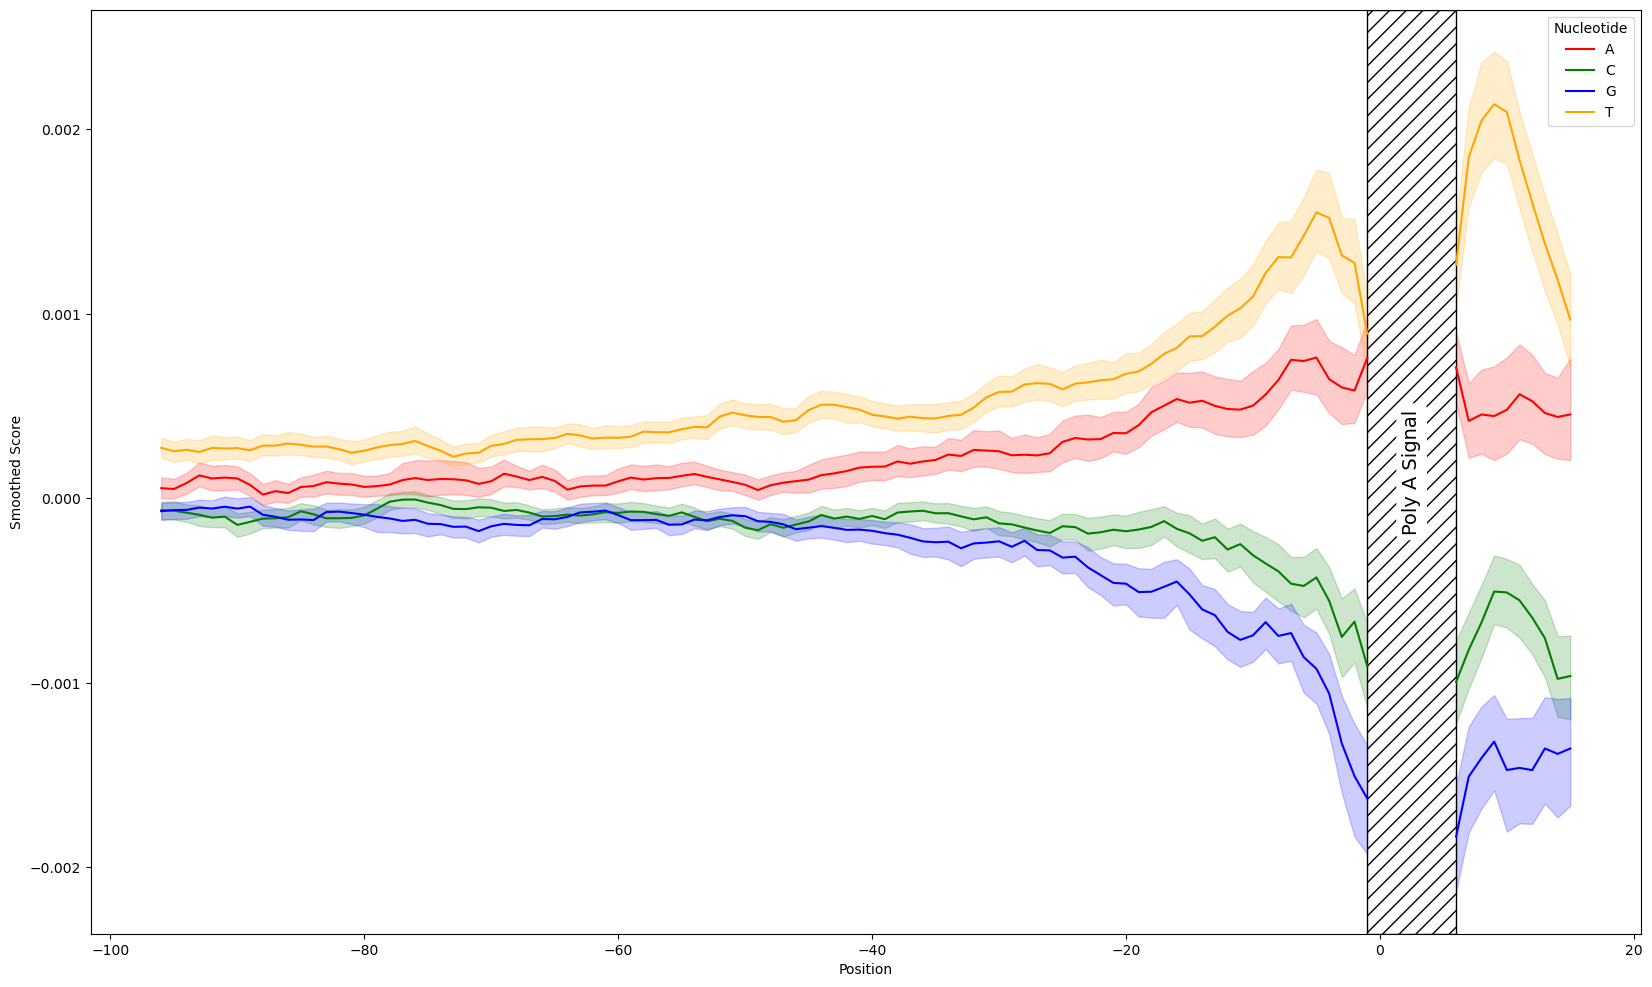

In [6]:
def smooth_df(df, reverse=False, window=5):
    # Create a copy of the dataframe to avoid modifying the original one
    df = df.copy()
    
    # Separate the dataframe into a dictionary of 4 dataframes
    df_dict = {nucleotide: df[df['Nucleotide'] == nucleotide] for nucleotide in nucleotides}
    
    # Apply the smoothing function to the 'Score' column in each dataframe in df_dict
    for nucleotide, df_nucleotide in df_dict.items():
        if reverse:
            df_nucleotide = df_nucleotide.sort_values('Position', ascending=False)
        df_nucleotide[f'Smoothed Score'] = df_nucleotide['Score'].rolling(window=window, min_periods=5).mean()
        if reverse:
            df_nucleotide.sort_values('Position', ascending=True, inplace=True)
        df_dict[nucleotide] = df_nucleotide

    # Concatenate all dataframes in df_dict back into a single dataframe
    df_smooth = pd.concat(df_dict.values(), ignore_index=True)
    
    return df_smooth

# Define the list of nucleotides and their corresponding colors for the plot
nucleotides = ['A','C','G','T']
colors = ['red', 'green', 'blue', 'orange']

# Load the dataframe from csv
df = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/LIN28A_associated/results/Trying_CNNs/analysis13_MachineLearningOnQuantSeqGroups/importance_around_polyA_signal.csv')

df_plot_1 = df[df['Position'] <= -1]
df_plot_2 = df[df['Position'] >= 6]

# Apply the smoothing function to each sequence in df_plot_1 and df_plot_2
df_plot_1_smooth = df_plot_1.groupby('Sequence Index').apply(smooth_df)
df_plot_2_smooth = df_plot_2.groupby('Sequence Index').apply(lambda df: smooth_df(df, reverse=True))

# Reset the index for both dataframes
df_plot_1_smooth.reset_index(drop=True, inplace=True)
df_plot_2_smooth.reset_index(drop=True, inplace=True)

# Create a line plot with confidence intervals
plt.figure(figsize=(20, 12))
sns.lineplot(x='Position', y='Smoothed Score', hue='Nucleotide', data=df_plot_1_smooth, palette=colors)
sns.lineplot(x='Position', y='Smoothed Score', hue='Nucleotide', data=df_plot_2_smooth, palette=colors, legend=False)

# Draw a vertical bar from -2 to 4 nucleotide position with black and white criss-cross pattern
bar_x_start = -1
bar_x_end = 6
bar_height = plt.ylim()[1] - plt.ylim()[0]  # Calculate the height of the bar based on y-axis limits

bar = patches.Rectangle((bar_x_start, plt.ylim()[0]), bar_x_end - bar_x_start, bar_height,
                         hatch='//', facecolor='none', edgecolor='black')
plt.gca().add_patch(bar)

# Add "Poly A Site" label to the bar vertically
text_x_pos = (bar_x_start + bar_x_end) / 2  # Calculate the midpoint of the bar for x-coordinate
text_y_pos = plt.ylim()[0] + (bar_height / 2)  # Calculate the midpoint of the bar for y-coordinate

text_box_props = dict(boxstyle='round', facecolor='white', edgecolor='none')
plt.text(text_x_pos, text_y_pos, 'Poly A Signal', ha='center', va='center', rotation='vertical',
         fontsize=14, bbox=text_box_props)

# export plot as svg
plt.savefig('average_contribution_scores_polya_new.svg', bbox_inches='tight')

# Display the plot
plt.show()

**Use TF-Modisco Lite to find motifs in contribution scores of DOWN predicted genes.**

In [ ]:
hot_endcoded_seqs_down_all = np.load('analysis13_MachineLearningOnQuantSeqGroups/hot-endcoded-seqs_down_all.npy', allow_pickle=True)
contribution_scores_down_all = np.load('analysis13_MachineLearningOnQuantSeqGroups/contribution-scores_down_all.npy', allow_pickle=True)

# Convert the hot_endcoded_seqs_down_all array to a numpy array with correct shape
hot_endcoded_seqs_down_all_numeric = np.concatenate(hot_endcoded_seqs_down_all).reshape(-1, 3425, 4)

# Transpose the hot_endcoded_seqs_down_all array to 0,2,1 as per TF-modisco requirements
hot_endcoded_seqs_down_all_for_modisco = np.transpose(hot_endcoded_seqs_down_all_numeric, (0,2,1))
contribution_scores_down_all_for_modisco = np.transpose(contribution_scores_down_all, (0,2,1))

# Export all down numpy files so we get input for TF modisco
np.save('analysis13_MachineLearningOnQuantSeqGroups/hot_endcoded_seqs_down_all_for_modisco.npy', hot_endcoded_seqs_down_all_for_modisco)
np.save('analysis13_MachineLearningOnQuantSeqGroups/contribution_scores_down_all_for_modisco.npy', contribution_scores_down_all_for_modisco)


In [55]:
%%bash
mkdir -p analysis13_MachineLearningOnQuantSeqGroups/modisco_output

OUTPATH="analysis13_MachineLearningOnQuantSeqGroups/modisco_output/modisco_results.h5"

modisco motifs \
-s hot_endcoded_seqs_down_all_for_modisco.npy \
-a contribution_scores_down_all_for_modisco.npy \
-n 1000 \
-l 10 \
-w 150 \
-o $OUTPATH

OUTPATH="analysis13_MachineLearningOnQuantSeqGroups/modisco_output/modisco_results"
mkdir -p $OUTPATH
modisco report \
    -i "analysis13_MachineLearningOnQuantSeqGroups/modisco_output/modisco_results.h5" \
    -o $OUTPATH